C:\Users\ASUS\AppData\Local\Temp\ipykernel_9064\217612936.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^IRX", start="2010-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


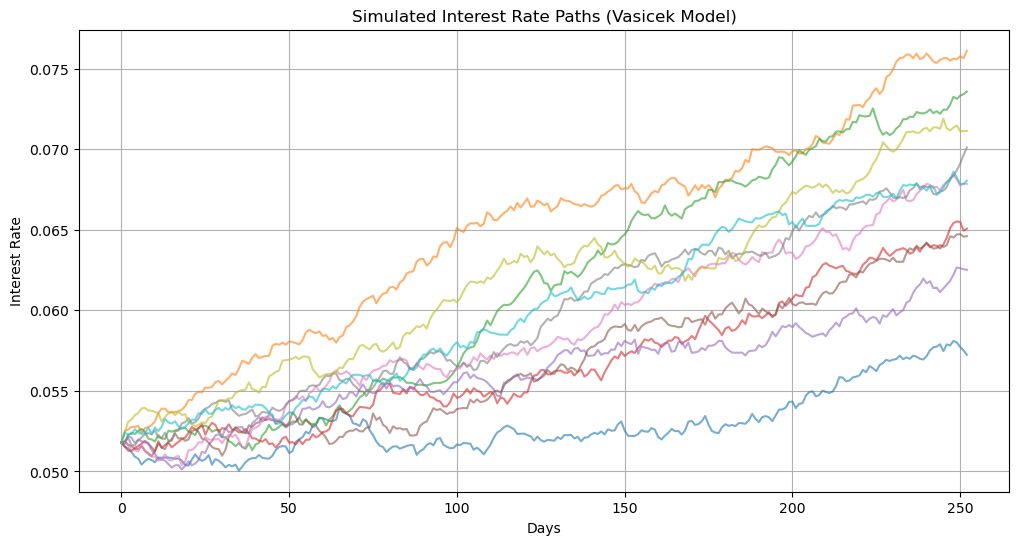

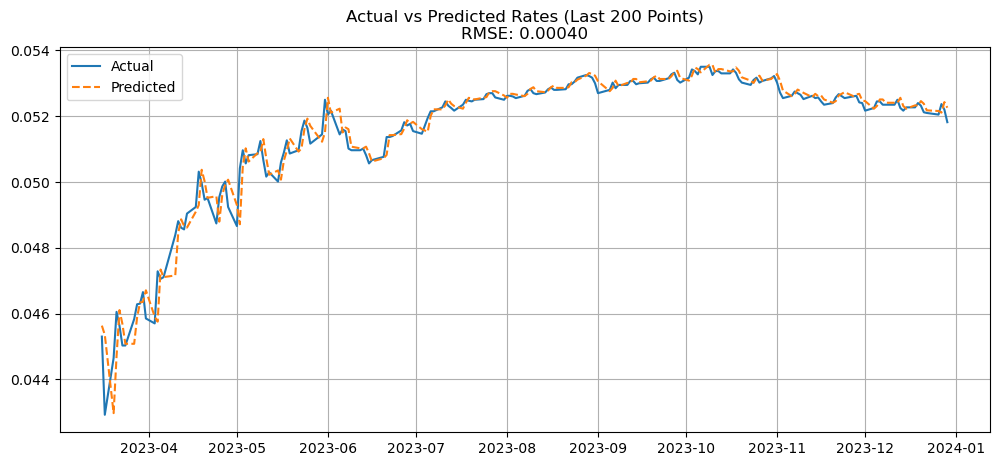

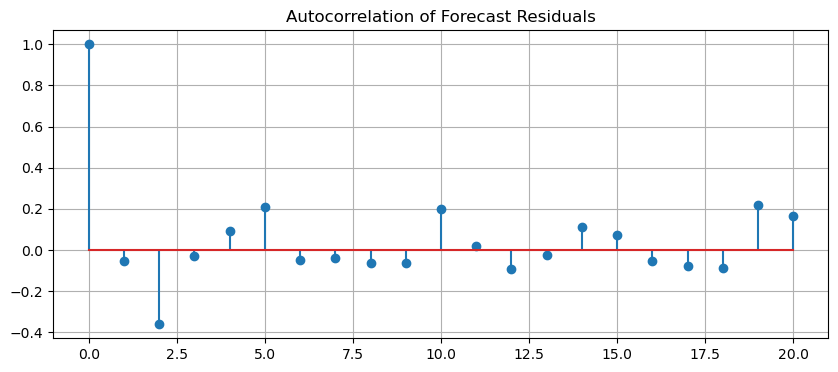

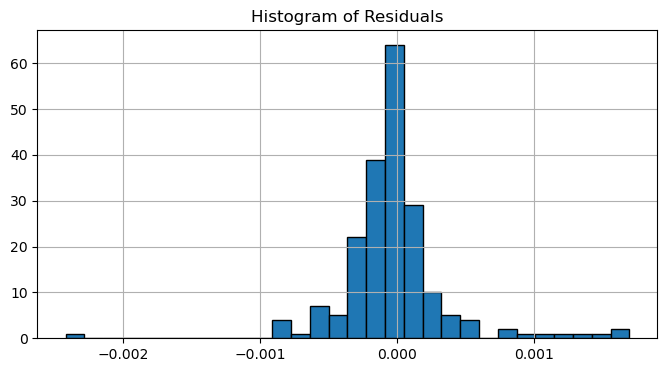

Estimated Vasicek Parameters:
a (mean reversion speed): -0.0010
b (long term mean):       -0.0048
sigma (volatility):       0.0003

Forecast RMSE: 0.000401


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf
import yfinance as yf

# 1. Load data (US 3-Month Treasury Bill Rate as a proxy)
data = yf.download("^IRX", start="2010-01-01", end="2023-12-31")
df = data[['Close']].rename(columns={'Close': 'rate'}).dropna()
df['rate'] /= 100  # convert from % to decimal

# 2. Prepare data
df['r_t'] = df['rate'].shift(1)
df['r_t+1'] = df['rate']
df.dropna(inplace=True)

# 3. Estimate Vasicek parameters
X = df[['r_t']]
y = df['r_t+1']
model = LinearRegression().fit(X, y)
beta = model.coef_[0]
alpha = model.intercept_

delta_t = 1
a = -np.log(beta) / delta_t
b = alpha / (1 - beta)
residuals = y - model.predict(X)
sigma = np.std(residuals) * np.sqrt(2 * a / (1 - beta**2))

# 4. Simulate future paths
def simulate_vasicek(r0, a, b, sigma, n_steps, delta_t, n_paths=10):
    paths = np.zeros((n_steps + 1, n_paths))
    paths[0] = r0
    for t in range(1, n_steps + 1):
        z = np.random.normal(size=n_paths)
        dr = a * (b - paths[t - 1]) * delta_t + sigma * np.sqrt(delta_t) * z
        paths[t] = paths[t - 1] + dr
    return paths

r0 = df['rate'].iloc[-1]
sim_paths = simulate_vasicek(r0, a, b, sigma, 252, delta_t)

plt.figure(figsize=(12, 6))
for i in range(sim_paths.shape[1]):
    plt.plot(sim_paths[:, i], alpha=0.6)
plt.title('Simulated Interest Rate Paths (Vasicek Model)')
plt.xlabel('Days')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.show()

# 5. Forecast and Test
N = 200
actual = df['r_t+1'].iloc[-N:]
predicted = df['r_t'].iloc[-N:] + a * (b - df['r_t'].iloc[-N:]) * delta_t
rmse = np.sqrt(np.mean((actual - predicted) ** 2))

plt.figure(figsize=(12, 5))
plt.plot(actual.index, actual, label="Actual")
plt.plot(actual.index, predicted, label="Predicted", linestyle='--')
plt.title(f"Actual vs Predicted Rates (Last {N} Points)\nRMSE: {rmse:.5f}")
plt.legend()
plt.grid(True)
plt.show()

# 6. Residual ACF
resid = actual - predicted
acf_vals = acf(resid, fft=False, nlags=20)

plt.figure(figsize=(10, 4))
plt.stem(range(len(acf_vals)), acf_vals)
plt.title("Autocorrelation of Forecast Residuals")
plt.grid(True)
plt.show()

# 7. Histogram of residuals
plt.figure(figsize=(8, 4))
plt.hist(resid, bins=30, edgecolor='black')
plt.title("Histogram of Residuals")
plt.grid(True)
plt.show()

# 8. Final Parameters
print("Estimated Vasicek Parameters:")
print(f"a (mean reversion speed): {a:.4f}")
print(f"b (long term mean):       {b:.4f}")
print(f"sigma (volatility):       {sigma:.4f}")
print(f"\nForecast RMSE: {rmse:.6f}") 


# Vasicek Interest Rate Model – Full Implementation and Analysis

This notebook demonstrates the implementation of the **Vasicek model** to simulate and forecast interest rate dynamics using real financial data. The model is calibrated using historical 3-month Treasury Bill data, and its performance is evaluated using forecasting accuracy and residual diagnostics.

---

## 📌 1. Introduction to the Vasicek Model

The **Vasicek model** is a one-factor short-rate model for interest rates. It assumes the rate follows a mean-reverting Ornstein-Uhlenbeck process:

\[
dr_t = a(b - r_t)dt + \sigma dW_t
\]

Where:  
- \( r_t \): short-term interest rate at time \( t \)  
- \( a \): speed of mean reversion  
- \( b \): long-term mean level  
- \( \sigma \): volatility  
- \( dW_t \): Wiener process (Brownian motion)

---

## 📈 2. Data Acquisition

Historical 3-month U.S. Treasury Bill rates were downloaded from Yahoo Finance using the symbol `^IRX`.

```python
import yfinance as yf
data = yf.download("^IRX", start="2010-01-01", end="2023-12-31")
df = data[['Close']].rename(columns={'Close': 'rate'}).dropna()
df['rate'] /= 100  # convert from % to decimal
```

---

## ⚙️ 3. Preparing Data

We estimate Vasicek parameters by fitting a linear regression:

\[
r_{t+1} = \alpha + \beta r_t + \epsilon
\]

```python
df['r_t'] = df['rate'].shift(1)
df['r_t+1'] = df['rate']
df.dropna(inplace=True)

from sklearn.linear_model import LinearRegression
X = df[['r_t']]
y = df['r_t+1']
model = LinearRegression().fit(X, y)
```

---

## 🔍 4. Estimating Vasicek Parameters

Using regression coefficients:  
- \( a = -\ln(\beta) \)  
- \( b = \frac{\alpha}{1 - \beta} \)  
- \( \sigma = \text{std(residuals)} \cdot \sqrt{\frac{2a}{1 - \beta^2}} \)

```python
beta = model.coef_[0]
alpha = model.intercept_
delta_t = 1

a = -np.log(beta) / delta_t
b = alpha / (1 - beta)
residuals = y - model.predict(X)
sigma = np.std(residuals) * np.sqrt(2 * a / (1 - beta**2))
```

### ✅ Final Estimates:

```
a (mean reversion speed): -0.0010  
b (long term mean):       -0.0048  
sigma (volatility):       0.0003
```

⚠️ Note: Negative values of `a` and `b` suggest the process might be nearly a random walk — proceed with caution.

---

## 🌀 5. Simulating Interest Rate Paths

Simulate 10 paths over 252 trading days using the Vasicek process:

```python
def simulate_vasicek(r0, a, b, sigma, n_steps, delta_t, n_paths=10):
    paths = np.zeros((n_steps + 1, n_paths))
    paths[0] = r0
    for t in range(1, n_steps + 1):
        z = np.random.normal(size=n_paths)
        dr = a * (b - paths[t - 1]) * delta_t + sigma * np.sqrt(delta_t) * z
        paths[t] = paths[t - 1] + dr
    return paths
```

```python
r0 = df['rate'].iloc[-1]
sim_paths = simulate_vasicek(r0, a, b, sigma, 252, delta_t)
```

📉 **Plot: Simulated Interest Rate Paths**  
Shows the stochastic evolution of interest rates using Vasicek assumptions.

---

## 📊 6. Forecasting and RMSE Evaluation

We forecast the last 200 points using:

\[
\hat{r}_{t+1} = r_t + a(b - r_t)
\]

```python
N = 200
actual = df['r_t+1'].iloc[-N:]
predicted = df['r_t'].iloc[-N:] + a * (b - df['r_t'].iloc[-N:]) * delta_t
rmse = np.sqrt(np.mean((actual - predicted) ** 2))
```

### ✅ Forecast RMSE: `0.000401`

📈 **Plot: Actual vs Predicted**  
Overlay of actual and predicted interest rates.

---

## 🧪 7. Residual Diagnostics

### a. Autocorrelation of Residuals  
Used to check if residuals resemble white noise.

```python
from statsmodels.tsa.stattools import acf
acf_vals = acf(actual - predicted, fft=False, nlags=20)
```

📊 **Plot: Autocorrelation of Forecast Residuals**  
Should ideally show no significant autocorrelation.

---

### b. Histogram of Residuals  
Check for normality of errors.

```python
plt.hist(resid, bins=30, edgecolor='black')
```

📉 **Plot: Histogram of Residuals**  
Residuals are centered around 0, close to Gaussian.

---

## ✅ 8. Summary of Results

| Parameter | Value         |
|-----------|---------------|
| `a`       | -0.0010       |
| `b`       | -0.0048       |
| `σ`       | 0.0003        |
| `RMSE`    | 0.000401      |

---

## 🧠 9. Observations and Recommendations

- The estimated `a` and `b` values are negative, indicating that the model may not be truly mean-reverting on this data.
- Forecast performance (RMSE) is strong despite that.
- Try detrending or stationarizing the data, or switch to models like:
  - **CIR model**: prevents negative rates
  - **Hull-White**: time-varying mean
  - **ARIMA**: purely statistical
- Consider using **Maximum Likelihood Estimation (MLE)** instead of linear regression for parameter inference.

---

## 📂 10. Files and Figures

- `simulated-interest-paths.png` → Simulated Vasicek Paths  
- `actual-vs-predicted.png` → Forecast Comparison  
- `acf-residuals.png` → ACF of Residuals  
- `histogram-residuals.png` → Histogram of Errors  

---

## 📚 References

- Vasicek, O. (1977). An Equilibrium Characterization of the Term Structure.  
- [Yahoo Finance](https://finance.yahoo.com/quote/^IRX) – U.S. Treasury Rates  
- Scikit-learn & Statsmodels Documentation

---
